## Предсказание константы ингибирования

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint, EpochScoring
from skorch.dataset import Dataset, ValidSplit

import warnings
warnings.filterwarnings('ignore')

Загружаем данные и разделим их на тренировочные и тестовые

In [23]:
data = pd.read_csv("train_datacet.csv", sep=",")
data.head()

,Unnamed: 0,molecule_chembl_id,smiles,pValue,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,Morgan_Fingerprint
0,0,CHEMBL298445,Cc1nc(N)sc1-c1ccnc(Nc2cccc([N+](=O)[O-])c2)n1,7.69897,0.175340,-1.916410,-1.177015,1.303410,-1.940371,-3.457689,...,-0.439231,-0.705320,-1.484948,-1.497831,-0.519799,-0.283873,-0.934489,0.562354,-0.249046,[0 0 0 ... 0 0 0]
1,1,CHEMBL182493,Cc1ccc2c(-c3ccnc(Nc4cccc(C(F)(F)F)c4)n3)c(-c3c...,7.69897,4.830320,4.720097,-6.048858,4.901976,0.494477,1.556537,...,-0.723885,-0.207798,-0.466748,-0.532699,0.229258,-0.164938,-0.125851,0.165480,0.216871,[0 0 0 ... 0 0 0]
2,2,CHEMBL182326,Cc1ccc2c(-c3ccnc(Nc4ccc(F)c(F)c4)n3)c(-c3ccc(F...,8.00000,2.954056,5.070312,-3.667544,3.299032,0.748056,-0.241208,...,0.898658,-1.051557,0.325509,-0.103288,-0.448536,0.023578,-0.417369,0.287566,-0.444571,[0 0 0 ... 0 0 0]
3,3,CHEMBL183064,Cc1ccc2c(-c3ccnc(Nc4ccc5c(c4)OCCO5)n3)c(-c3ccc...,8.00000,4.454018,4.352885,0.604514,2.185117,3.246041,-1.878639,...,-0.448741,-0.813763,-0.938472,-0.012356,0.175566,0.988425,0.001853,0.525168,-0.134933,[0 0 0 ... 0 0 0]
4,4,CHEMBL361038,Cc1ccc2c(-c3ccnc(Nc4ccc(Cl)c(C(F)(F)F)c4)n3)c(...,7.30103,5.168279,4.331109,-6.495174,4.907972,-0.932461,1.105451,...,-1.016014,-0.296998,-0.014852,-0.553451,0.168620,-0.039798,-0.195770,0.168756,0.161863,[0 0 0 ... 0 0 0]


In [24]:
X, y  = data.drop(columns=["Unnamed: 0", "molecule_chembl_id", "smiles", "pValue", "Morgan_Fingerprint"]),  data["pValue"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Подготовка данных для обучения нейросетевых моделей
X_train_values = X_train.values if hasattr(X_train, 'values') else X_train
X_test_values = X_test.values if hasattr(X_test, 'values') else X_test
y_train_values = y_train.values if hasattr(y_train, 'values') else y_train
y_test_values = y_test.values if hasattr(y_test, 'values') else y_test

X_train_tensor = torch.FloatTensor(X_train_values)
y_train_tensor = torch.FloatTensor(y_train_values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_values)
y_test_tensor = torch.FloatTensor(y_test_values).view(-1, 1)

Определим интересующие нас модели, создадим словарь с вариантами гиперпараметров и функцию для подсчета метрик

In [27]:
# Определение нейросетевых моделей
class MLP(nn.Module):
    def __init__(self, input_size=56, hidden_size=100, dropout=0.2):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1)
        )
    
    def forward(self, x):
        return self.net(x)

class CNN(nn.Module):
    def __init__(self, input_size=56, num_channels=64, dropout=0.3):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, num_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_size)
            conv_out_size = self.conv(dummy).shape[1]
            
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 100),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(100, 1)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)
        return self.fc(self.conv(x))

# Обертки для использования с GridSearchCV (библиотека skorch)
r2_callback = EpochScoring(
    'r2',
    name='valid_r2',
    lower_is_better=False,
    on_train=False
)

mlp_net = NeuralNetRegressor(
    module=MLP,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=100,
    batch_size=64,
    callbacks=[EarlyStopping(patience=10), r2_callback],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0,
    train_split=ValidSplit(cv=0.2)
)

cnn_net = NeuralNetRegressor(
    module=CNN,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=100,
    batch_size=64,
    callbacks=[EarlyStopping(patience=10), r2_callback],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0,
    train_split=ValidSplit(cv=0.2)
)

In [28]:
# Модели и их параметры для GridSearch
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'gamma': [0, 0.1, 0.2],
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 50, 63, 127],
            'max_depth': [-1, 5, 10]
        }
    },
    'MLP (PyTorch)': {
        'model': mlp_net,
        'params': {
            'module__hidden_size': [100, 200],
            'module__dropout': [0.1, 0.2, 0.3],
            'optimizer__lr': [0.001, 0.005, 0.01, 0.05]
        }
    },
    'CNN (PyTorch)': {
        'model': cnn_net,
        'params': {
            'module__num_channels': [32, 64],
            'module__dropout': [0.1, 0.2, 0.3],
            'optimizer__lr': [0.001, 0.005, 0.01, 0.05]
        }
    }
}

In [29]:
# Функция для оценки модели
def evaluate_model(y_true, y_pred, model_name, eval_type):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    results = {
        'Model': model_name,
        'Evaluation': eval_type,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    return results

Добавим функции для визуализации процесса обучения

In [30]:
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score (R²)")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        scoring='r2', train_sizes=np.linspace(.1, 1.0, 5)
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Модифицированная функция для нейросетевых моделей
def plot_nn_training(net):
    plt.figure(figsize=(12, 5))
    
    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(net.history[:, 'train_loss'], label='Train')
    plt.plot(net.history[:, 'valid_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(net.history[:, 'valid_r2'], label='R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.title('Validation R² Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Обучим модели с разными вариантами гиперпараметров и выберем наиболее оптимальную для нас


Training Random Forest...


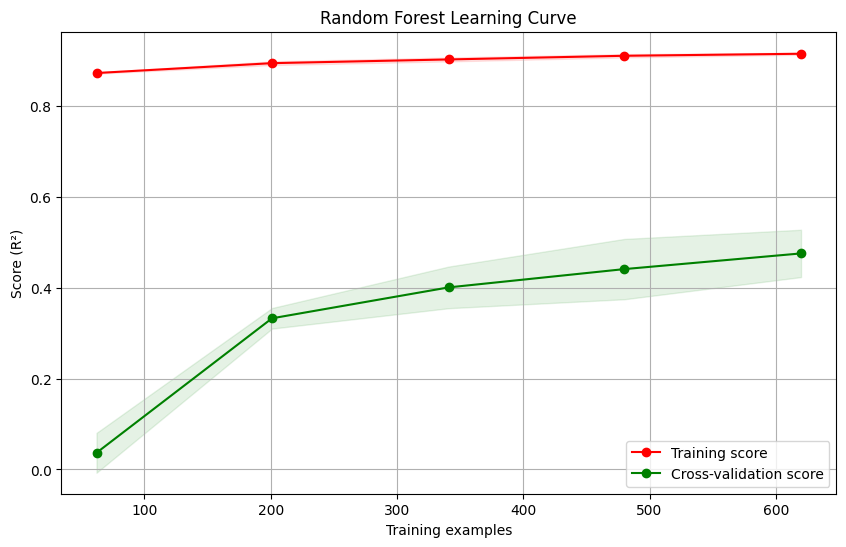

Best params for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Test R2: 0.3934

Training Gradient Boosting...


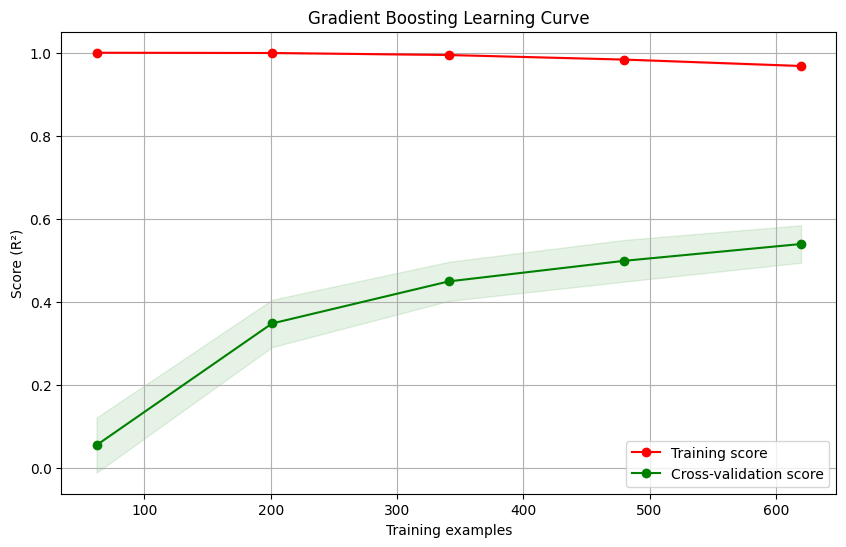

Best params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
Test R2: 0.4359

Training XGBoost...


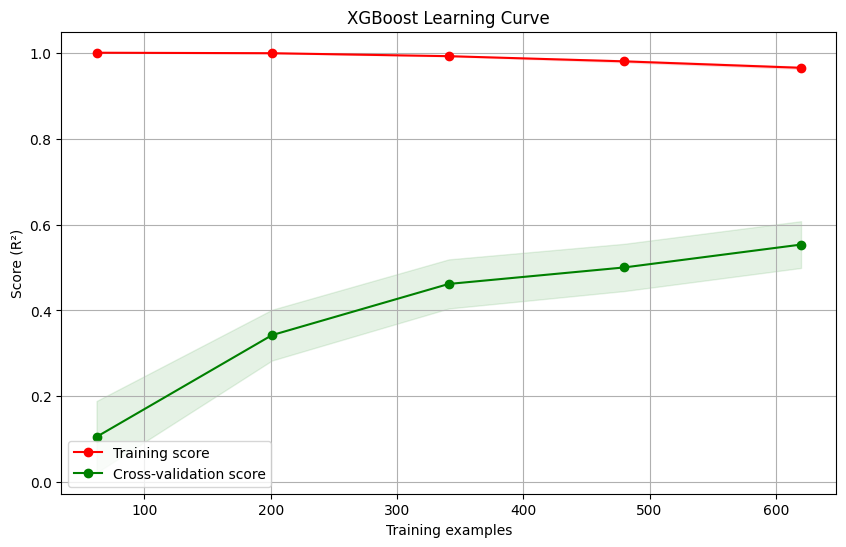

Best params for XGBoost: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Test R2: 0.4647

Training LightGBM...


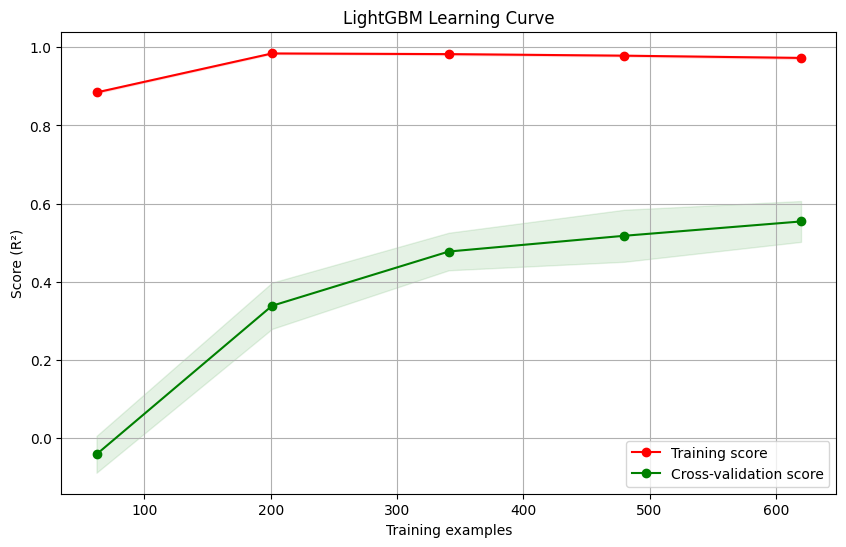

Best params for LightGBM: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 31}
Test R2: 0.4786

Training MLP (PyTorch)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


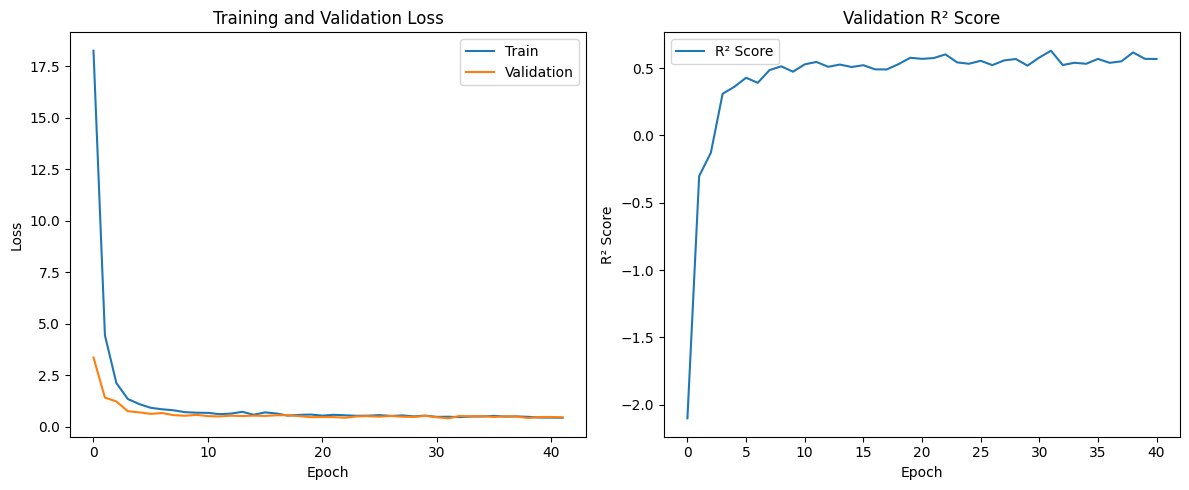

Best params for MLP (PyTorch): {'module__dropout': 0.3, 'module__hidden_size': 100, 'optimizer__lr': 0.005}
Test R2: 0.2753

Training CNN (PyTorch)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


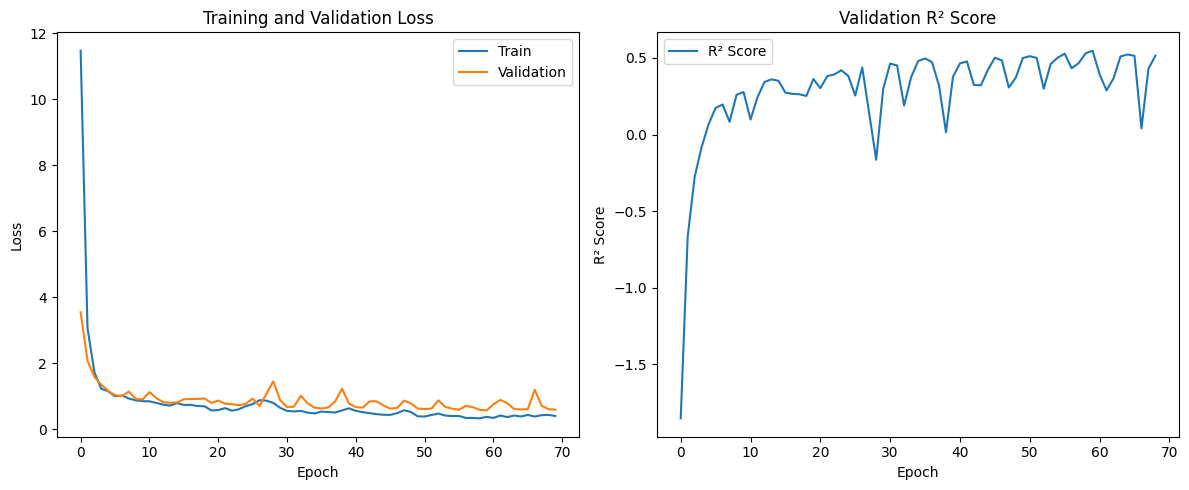

Best params for CNN (PyTorch): {'module__dropout': 0.1, 'module__num_channels': 32, 'optimizer__lr': 0.005}
Test R2: 0.1666


In [31]:
# Обучение и оценка моделей
results = []
best_model_info = {'name': None, 'model': None, 'r2': -float('inf')}

for model_name, model_data in models.items():
    print(f"\nTraining {model_name}...")
    
    # Подбор гиперпараметров
    if 'PyTorch' in model_name:
        gs = GridSearchCV(model_data['model'], model_data['params'], cv=5, scoring=scoring, refit='RMSE', n_jobs=1, verbose=1)
        gs.fit(X_train_tensor, y_train_tensor)
        best_model = gs.best_estimator_
        
        y_train_pred = best_model.predict(X_train_tensor)
        y_test_pred = best_model.predict(X_test_tensor)
    
        plot_nn_training(best_model)

    else:
        gs = GridSearchCV(model_data['model'], model_data['params'], cv=5, scoring=scoring, refit='RMSE', n_jobs=-1)
        gs.fit(X_train, y_train)
        best_model = gs.best_estimator_

        plot_learning_curve(best_model, f"{model_name} Learning Curve", X_train, y_train, cv=5)
        
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
    
    # Оценка на тренировочных данных
    results.append(evaluate_model(y_train, y_train_pred, model_name, 'Train'))
    
    # Оценка на тестовых данных
    test_metrics = evaluate_model(y_test, y_test_pred, model_name, 'Test')
    results.append(test_metrics)

    # Оценка на кросс-валидации
    cv_metrics = {
        'MAE': -gs.cv_results_['mean_test_MAE'][gs.best_index_],
        'RMSE': -gs.cv_results_['mean_test_RMSE'][gs.best_index_],
        'R2': gs.cv_results_['mean_test_R2'][gs.best_index_]
    }
    
    results.append({
        'Model': model_name,
        'Evaluation': 'CV',
        'MAE': cv_metrics['MAE'],
        'RMSE': cv_metrics['RMSE'],
        'R2': cv_metrics['R2']
    })

    # Обновляем информацию о лучшей модели
    if test_metrics['R2'] > best_model_info['r2']:
        best_model_info = {
            'name': model_name,
            'model': best_model,
            'r2': test_metrics['R2']
        }
    
    print(f"Best params for {model_name}: {gs.best_params_}")
    print(f"Test R2: {test_metrics['R2']:.4f}")


All results:
                      MAE                    RMSE                      R2  \
Evaluation             CV    Test   Train      CV    Test   Train      CV   
Model                                                                       
CNN (PyTorch)      0.6585  0.6744  0.3908  0.8605  0.9051  0.5197  0.3545   
Gradient Boosting  0.5655  0.5692  0.1709  0.7232  0.7446  0.2263  0.5465   
LightGBM           0.5508  0.5600  0.1472  0.7070  0.7159  0.2011  0.5664   
MLP (PyTorch)      0.5723  0.5551  0.3574  0.7645  0.8440  0.4641  0.4781   
Random Forest      0.6217  0.6136  0.2366  0.7759  0.7722  0.3042  0.4780   
XGBoost            0.5606  0.5593  0.1779  0.7181  0.7254  0.2399  0.5518   

                                   
Evaluation           Test   Train  
Model                              
CNN (PyTorch)      0.1666  0.7684  
Gradient Boosting  0.4359  0.9561  
LightGBM           0.4786  0.9653  
MLP (PyTorch)      0.2753  0.8152  
Random Forest      0.3934  0.9206  
XGBo

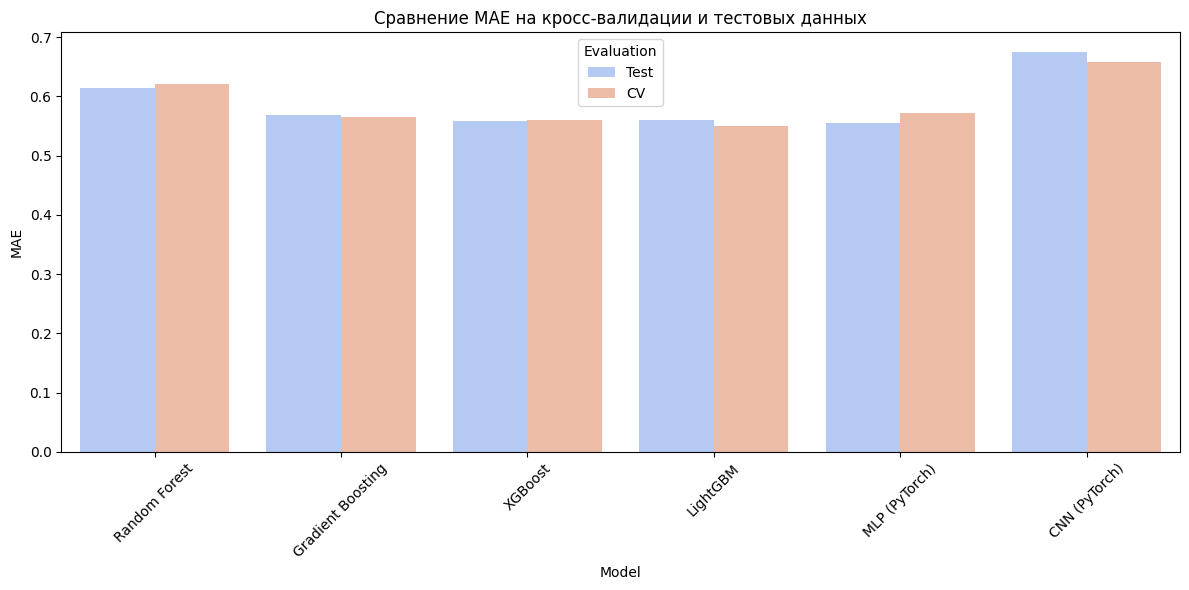

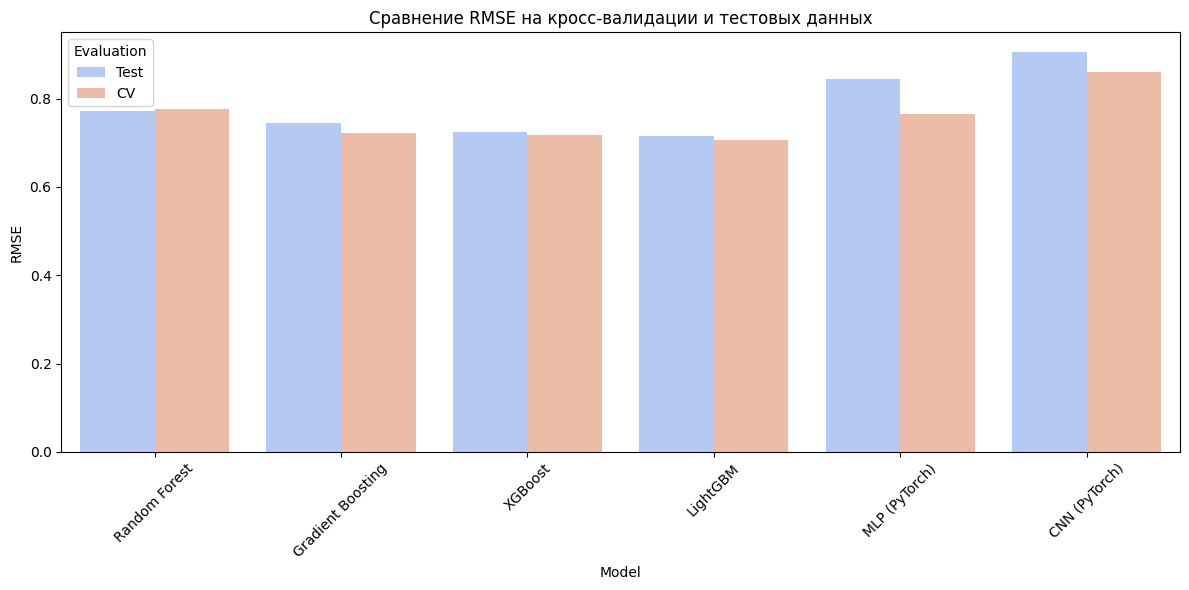

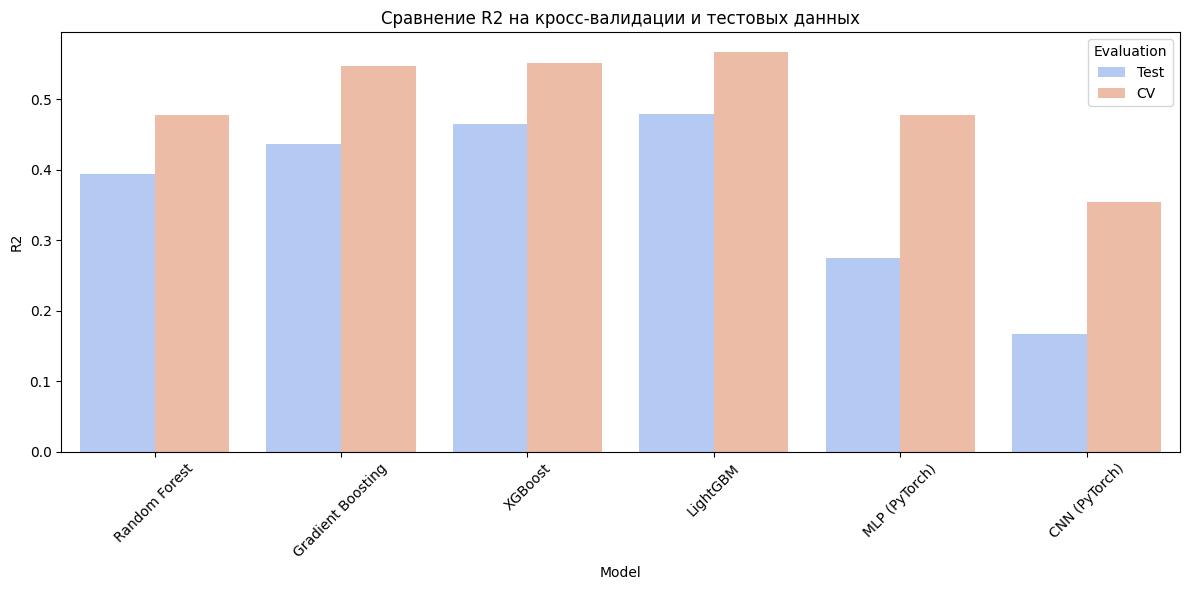


Best model: LightGBM


In [32]:
# Вывод результатов
results_df = pd.DataFrame(results)
print("\nAll results:")
print(results_df.pivot(index='Model', columns='Evaluation', values=['MAE', 'RMSE', 'R2']).round(4))

# Визуализация сравнения моделей на тестовых данных и кросс-валидации
metrics = ['MAE', 'RMSE', 'R2']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric, hue='Evaluation', 
                data=results_df[results_df['Evaluation'].isin(['CV', 'Test'])], 
                palette='coolwarm')
    plt.title(f'Сравнение {metric} на кросс-валидации и тестовых данных')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Выбираем лучшую модель по R2 на тестовых данных
print(f"\nBest model: {best_model_info['name']}")

Мы видим, что модели LGBM и XGBoost показали самые высокие результаты с т.з. минимизации ошибок и доли объясненной дисперсии. Для дальнейшей работы выберем LGBMRegressor с параметрами: learning_rate = 0.05, max_depth = 5, n_estimators = 200, num_leaves = 31

In [21]:
# Сохранение лучшей модели
if 'PyTorch' in best_model_info['name']:
    torch.save({'model_state_dict': best_model_info['model'].module_.state_dict(),
        'model_class': type(best_model_info['model'].module_),
        'best_params': best_model_info['model'].get_params()}, 'best_model.pth')
else:
    joblib.dump(best_model_info['model'], 'best_model.joblib')